# Multi-class Modeling

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Dataset Preparation](#Dataset-Preparation)
2. [Classifiers](#Classifiers)
3. [Bag-of-Words](#Bag-of-Words)
4. [Cross-Validation](#Cross-Validation)
5. [Hyperparameter Tuning](#Hyperparameter-Tuning)
6. [Predictions](#Predictions)

## Dataset Preparation

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import pandas as pd                # Data processing
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline

In [3]:
df = pd.read_csv('noun_chunks_classified.csv')
df['type'].value_counts()

not_skill     3459
hard_skill     468
soft_skill      73
Name: type, dtype: int64

As we can see the data set is not balanced. By far the most records describe the not_skill feature. Let's try some undersampling.

<AxesSubplot: >

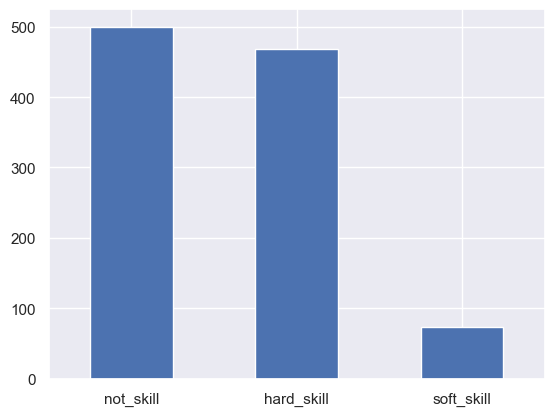

In [4]:
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=500)

df = pd.concat([df_skills, df_not_skills], ignore_index=True)

df['type'].value_counts().plot(kind='bar', rot=0)

Let's split the dataset into train and test sets for some initial fitting.

In [5]:
from sklearn.model_selection import train_test_split

# Extract features and prediction vectors
X = df['chunks']
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((728,), (313,))

## Classifiers

For this part I am going to train various classifiers and compare the training results. In detail the classifiers I will use are:

1. Multinomial Naive Bayes
2. Support Vector Machine
3. Linear Support Vector Machine
4. Random Forest
5. Logistic Regression

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

models = [
    MultinomialNB(),
    SVC(),
    LinearSVC(dual=False),
    RandomForestClassifier(),
    LogisticRegression()
]

## Bag-of-Words

The bag-of-words model is a simplified representation of corpus collection, often used in natural language processing. It is the way to transform text into numeric representations, used by the classifiers. In information retrieval `tf-idf` (term frequency–inverse document frequency) reflects the importance of a word in a document of the corpus.

In [7]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

print(np.shape(X_train_vec), np.shape(X_test_vec))

(728, 913) (313, 913)


Let's try to fit our models and measure the initial accuracy scores of the train and test sets.

In [8]:
measurements = []

for model in models:
    model.fit(X_train_vec, y_train)
    score_train = model.score(X_train_vec, y_train)
    score_test = model.score(X_test_vec, y_test)
    measurements.append([model.__class__.__name__, score_train, score_test])

results = pd.DataFrame(measurements, columns=['model', 'train_accuracy', 'test_accuracy'])
results

,model,train_accuracy,test_accuracy
0,MultinomialNB,0.895604,0.753994
1,SVC,0.973901,0.763578
2,LinearSVC,0.982143,0.769968
3,RandomForestClassifier,0.998626,0.760383
4,LogisticRegression,0.929945,0.750799


Let's check the most basic comparison of our models against the null accuracy score. This score will tell us if the models perform better than just selecting the most frequent class every time.

In [9]:
# Null Accuracy
class_choices = y_test.value_counts()
null_accuracy = class_choices[0] / sum(class_choices)

print('Null accuracy score: {0:0.4f}\n'.format(null_accuracy))

Null accuracy score: 0.4824



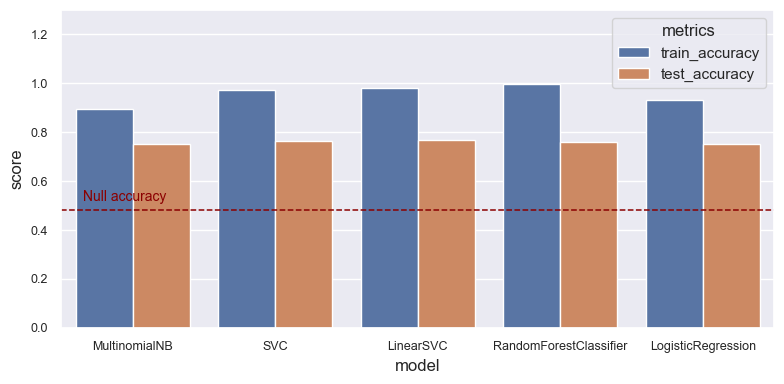

In [10]:
plt.figure(figsize=(8,4))

data_transformed = results.melt(id_vars='model', value_name='score', var_name='metrics')

metrics_plt = sns.barplot(data=data_transformed, x='model', y='score', hue='metrics')
metrics_plt.tick_params(labelsize=9)

plt.axhline(y=null_accuracy, ls='--', c='darkred', linewidth=1.1)
plt.text(-0.35, 0.52, 'Null accuracy', c='darkred', size='small')
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()

We can observe that all of the models perform way better than the "null accuracy" score. It means we have good first predictions.

Before we move on, let's see if we can improve these accuracies by fine tuning the TfIdf vectorizer.
One way is to increase the amount of n-grams to include more combinations than just unigrams.
We will also use the option `sublinear_tf` which is a form of penalty indicating that when a term is X times more frequent, it shouldn't be X times as important.

The scoring metric we are going to use is the `f1_score` function. As this is a multi-class setting, we will need to use one of these settings:

- weighted (favours the majority class)
- micro (no favoring)
- macro (bigger penalty due to poor performance on minority classes)

For this example we will use the micro setting.

In [11]:
from sklearn.metrics import f1_score

for n in range(1,11):
    # convert training data to bag of words
    vectorizer  = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, n), stop_words='english')
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)
    
    # train model and generate predictions
    scores = []
    for model in models:
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
    
        # compute f-1 score
        score = np.round(f1_score(y_test, y_pred, average='micro'), 5)
        scores.append(score)
    print('F1-score of n-gram range {}:\t {}'.format((1,n), scores))

F1-score of n-gram range (1, 1):	 [0.75399, 0.76677, 0.76997, 0.76038, 0.7508]
F1-score of n-gram range (1, 2):	 [0.7508, 0.72843, 0.75399, 0.75719, 0.74121]
F1-score of n-gram range (1, 3):	 [0.75719, 0.71885, 0.7508, 0.74121, 0.7508]
F1-score of n-gram range (1, 4):	 [0.76038, 0.72524, 0.76038, 0.75399, 0.74441]
F1-score of n-gram range (1, 5):	 [0.76038, 0.73163, 0.76038, 0.7476, 0.73802]
F1-score of n-gram range (1, 6):	 [0.76038, 0.73163, 0.76038, 0.73802, 0.73802]
F1-score of n-gram range (1, 7):	 [0.76038, 0.73163, 0.76038, 0.75399, 0.73802]
F1-score of n-gram range (1, 8):	 [0.76038, 0.73163, 0.75719, 0.7508, 0.73802]
F1-score of n-gram range (1, 9):	 [0.76038, 0.73163, 0.75719, 0.75719, 0.73802]
F1-score of n-gram range (1, 10):	 [0.76038, 0.73163, 0.75719, 0.76038, 0.73802]


As we can see the best value for n in most models seems to be 3. Let's make this selection.

In [12]:
vectorizer  = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3), stop_words='english')
X_vec = vectorizer.fit_transform(X)

## Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score

# Get cross validated scores for input models
def get_cross_val_scores(models, x, y):
    measurements = []
    for model in models:
        scores = cross_val_score(model, x, y, cv = 10, scoring = 'f1_micro')

        for i, score in enumerate(scores):
            measurements.append((model.__class__.__name__, i, score))

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'score'])
    return results

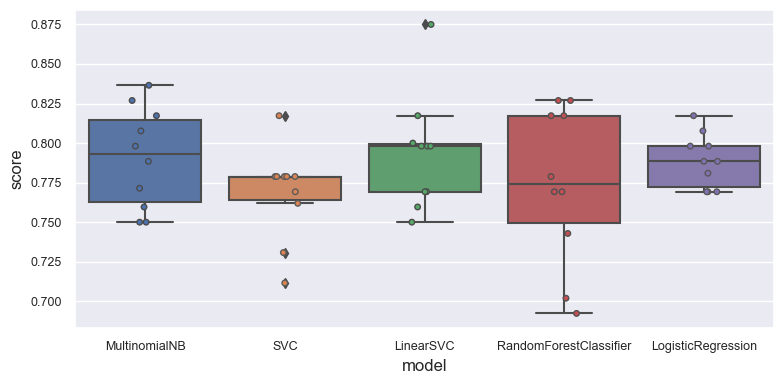

In [14]:
cv_results = get_cross_val_scores(models, X_vec, y)

plt.figure(figsize=(8,4))

cs_metrics_bxplt = sns.boxplot(x='model', y='score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='score', hue='model', data=cv_results,
                                 size=4, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

In [15]:
cv_results.groupby('model').score.mean().sort_values(ascending=False)

model
LinearSVC                 0.793462
MultinomialNB             0.790604
LogisticRegression        0.788672
RandomForestClassifier    0.774286
SVC                       0.768498
Name: score, dtype: float64

## Hyperparameter Tuning

The models we instatiated so far, could be potentially further improved by fine tuning their respective hyperparameter values. One process to perform hyperparameter tuning is called GridSearchCV, which exhaustively checks each pair of values to find the optimal. We will feed some sets of values to be checked into this process, as there is no way to find the best values for each hyperparameter in advance.

In [83]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter configurations for GridSearch
params_mnb = {'alpha': np.arange(0.01, 1, 0.01)}

params_svc = {'random_state': [0], 'C': np.arange(0.01, 1, 0.01), 'kernel':['rbf','linear'], 'gamma':['scale','auto'],
              'probability':[True,False], 'decision_function_shape':['ovo','ovr']}

params_lsv = {'random_state': [0], 'dual': [True], 'C': np.arange(0.01, 1, 0.01), 'multi_class': ['ovr', 'crammer_singer']}

params_rfc = {'random_state': [0], 'n_jobs': [-1], 'n_estimators': [50,100,200], 'min_samples_leaf': [1,2],
              'max_depth': [None,5], 'min_samples_split': [2,5], 'oob_score': [True,False],'warm_start': [True,False]}
              
params_lrc = {'random_state': [0], 'n_jobs': [-1], 'C': np.arange(0.01, 1, 0.01), 'warm_start': [True,False],
              'multi_class': ['multinomial']}

# Create the list of grid search models
grid_searches = [
    GridSearchCV(MultinomialNB(),          params_mnb, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(SVC(),                    params_svc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(LinearSVC(),              params_lsv, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(RandomForestClassifier(), params_rfc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(LogisticRegression(),     params_lrc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1)
]

In [17]:
import time

# Try to fit the models using the Grid Search and update models with optimal hyperparameters
index = 0
gs_scores = []
for gs in grid_searches:
    model_name = models[index].__class__.__name__
    
    start = time.time()
    gs.fit(X_vec, y)
    end = time.time()
    
    print(f'GridSearch for {model_name} finished after {end-start} seconds. Best parameters found:\n{gs.best_params_}')
    
    models[index] = gs.best_estimator_
    gs_scores.append((model_name, gs.best_score_))
    index += 1
gs_scores = pd.DataFrame(gs_scores, columns=['model', 'score'])

GridSearch for MultinomialNB finished after 5.7568769454956055 seconds. Best parameters found:
{'alpha': 0.25}
GridSearch for SVC finished after 670.7045578956604 seconds. Best parameters found:
{'C': 0.97, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'random_state': 0}


D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearch for LinearSVC finished after 5.8689985275268555 seconds. Best parameters found:
{'C': 0.9500000000000001, 'dual': False, 'multi_class': 'crammer_singer', 'random_state': 0}
GridSearch for RandomForestClassifier finished after 2660.012546777725 seconds. Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'warm_start': True}
GridSearch for LogisticRegression finished after 42.831995725631714 seconds. Best parameters found:
{'C': 0.99, 'multi_class': 'multinomial', 'n_jobs': -1, 'random_state': 0, 'warm_start': True}
[MultinomialNB(alpha=0.25), SVC(C=0.97, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=0), LinearSVC(C=0.9500000000000001, dual=False, multi_class='crammer_singer',
          random_state=0), RandomForestClassifier(min_samples_split=5, n_estimators=200, n_jobs=-1,
                       oob_score=

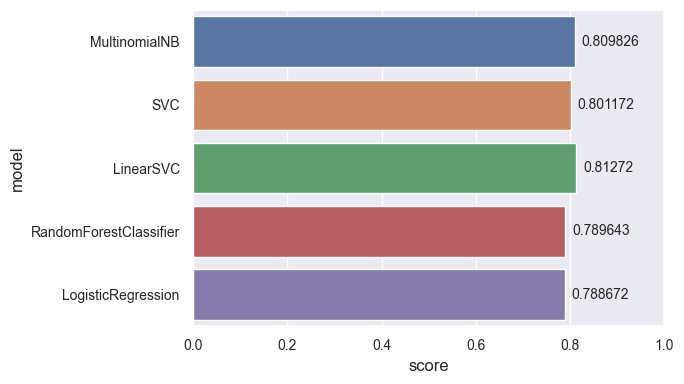

In [49]:
plt.figure(figsize=(7,4))

metrics_plt = sns.barplot(gs_scores, x='score', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)

plt.xlim(0, 1)
plt.tight_layout()
plt.show()

We can see that almost all models had a very small increase in their performance. The best models seem to be LinearSVC and Multinomial Naive Bayes.

## Predictions

In [84]:
from modeling.database import MongoDB
db = MongoDB()
df = pd.DataFrame(list(db.get_all_documents()))

In [85]:
df['description'] = df['description'].apply(lambda x: x.lower())               # Convert to lower case
df['description'] = df['description'].str.replace(r'[^\w\s]', ' ', regex=True) # Remove special characters
df['description'] = df['description'].str.replace(r'\d+', '', regex=True)      # Remove digits
df['description'] = df['description'].str.replace(r'\s*\n+', ' ', regex=True)  # Remove new lines and whitespaces
df['description'] = df['description'].str.replace('e g', '')

In [87]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

noun_phrases = []
for doc in nlp.pipe(df['description'].astype('unicode').values, batch_size=50, n_process=3):
    assert doc.has_annotation("DEP")
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text)

nouns_phrases_set = list(set(noun_phrases))
len(nouns_phrases_set)

11802

In [89]:
df = pd.DataFrame(nouns_phrases_set, columns=["chunks"])

In [106]:
#complete_vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3), stop_words='english')

X_dataset_vec = vectorizer.transform(df['chunks'])
X_dataset_vec.shape

(11802, 4262)

In [179]:
best_model = models[gs_scores['score'].idxmax()]

y_pred = best_model.predict(X_dataset_vec)
df['prediction'] = y_pred

In [180]:
pd.Series(" ".join(df[df['prediction']==1]['chunks']).split()).value_counts()[:25]

from nltk import pos_tag
from nltk.tokenize import word_tokenize

skill_types = {
    "not_skill": 0,
    "hard_skill": 1,
    "soft_skill": 2
}

skill_type = skill_types["hard_skill"]

noun = []
for index, row in enumerate(df[df['prediction']==skill_type]['chunks'].apply(lambda x: word_tokenize(x))):
    extracted = [word for word, pos in pos_tag(row) if pos.startswith('N')]
    if not extracted:
        continue
    print(f'Tools exctracted: {extracted}')
    noun.extend(extracted)

Tools exctracted: ['data', 'chapter']
Tools exctracted: ['sql', 'queries']
Tools exctracted: ['analytics']
Tools exctracted: ['workflow', 'tools']
Tools exctracted: ['science', 'mathematics', 'statistics', 'machine', 'technology', 'data']
Tools exctracted: ['data', 'engineering', 'knowledge']
Tools exctracted: ['cloud', 'data', 'warehouse']
Tools exctracted: ['classification', 'prediction', 'recommendation', 'forecasting']
Tools exctracted: ['learning', 'techniques']
Tools exctracted: ['sql', 'knowledge']
Tools exctracted: ['version', 'control', 'ability']
Tools exctracted: ['etl', 'elt', 'design']
Tools exctracted: ['azure', 'gcp', 'familiarity']
Tools exctracted: ['phd', 'research', 'project', 'phd']
Tools exctracted: ['value', 'reporting', 'data', 'visualization', 'capabilities']
Tools exctracted: ['tools', 'techniques']
Tools exctracted: ['experience', 'data', 'data']
Tools exctracted: ['data', 'controller']
Tools exctracted: ['supply', 'data', 'lake']
Tools exctracted: ['ai', 'ml'

Tools exctracted: ['analytics', 'machine', 'learning', 'methodologies', 'sql']
Tools exctracted: ['field', 'knowledge']
Tools exctracted: ['procurement', 'data', 'warehouse']
Tools exctracted: ['machine', 'systems']
Tools exctracted: ['dbs']
Tools exctracted: ['tools']
Tools exctracted: ['data', 'pipelines']
Tools exctracted: ['python', 'experience', 'building', 'data', 'reports']
Tools exctracted: ['python', 'databases']
Tools exctracted: ['skills', 'attention']
Tools exctracted: ['process', 'design']
Tools exctracted: ['data', 'tables']
Tools exctracted: ['data', 'data']
Tools exctracted: ['data', 'science', 'analytics']
Tools exctracted: ['ml', 'experiments']
Tools exctracted: ['data', 'science', 'experience', 'coding', 'skills']
Tools exctracted: ['trade', 'python', 'git']
Tools exctracted: ['cloud', 'apache']
Tools exctracted: ['bs', 'ms']
Tools exctracted: ['discipline', 'statistics', 'computer', 'science', 'math', 'engineering']
Tools exctracted: ['msc', 'phd']
Tools exctracted:

Tools exctracted: ['data', 'visualization', 'presentation']
Tools exctracted: ['statistics']
Tools exctracted: ['processes']
Tools exctracted: ['positions']
Tools exctracted: ['ml', 'library']
Tools exctracted: ['data', 'design', 'patterns']
Tools exctracted: ['engine', 'data', 'factory']
Tools exctracted: ['data', 'analysis', 'tools']
Tools exctracted: ['ai', 'ml', 'expertise']
Tools exctracted: ['languages']
Tools exctracted: ['project', 'proposals', 'skills']
Tools exctracted: ['python', 'pandas']
Tools exctracted: ['tools']
Tools exctracted: ['data', 'lifecycle']
Tools exctracted: ['spark', 'years']
Tools exctracted: ['data', 'science', 'deliverables']
Tools exctracted: ['flask', 'hands']
Tools exctracted: ['design', 'modelling']
Tools exctracted: ['data']
Tools exctracted: ['pytorch', 'tensorflow', 'keras']
Tools exctracted: ['computer', 'science', 'data', 'science', 'mathematics']
Tools exctracted: ['azure', 'gcp', 'teradata', 'requirements']
Tools exctracted: ['abilities', 'prob

Tools exctracted: ['data', 'processor']
Tools exctracted: ['level', 'skills']
Tools exctracted: ['core']
Tools exctracted: ['bain', 'uber', 'lyft', 'gojek', 'lazada', 'alibaba']
Tools exctracted: ['oracle', 'data', 'warehouse', 'builder']
Tools exctracted: ['analysis', 'framework', 'models']
Tools exctracted: ['edge', 'machine', 'algorithms']
Tools exctracted: ['computer', 'science', 'statistics', 'mathematics', 'engineering', 'physics']
Tools exctracted: ['architecture', 'snowflake']
Tools exctracted: ['json', 'yaml', 'familiarity']
Tools exctracted: ['azure', 'spring', 'batch']
Tools exctracted: ['master', 'data', 'creation']
Tools exctracted: ['analysts']
Tools exctracted: ['master', 'degree']
Tools exctracted: ['power', 'bi']
Tools exctracted: ['machine', 'model', 'churn']
Tools exctracted: ['data', 'procedures']
Tools exctracted: ['machine', 'learning', 'features']
Tools exctracted: ['bi', 'loyalty', 'analytics', 'department']
Tools exctracted: ['computer', 'science', 'business', 

Tools exctracted: ['classes']
Tools exctracted: ['python', 'libraries']
Tools exctracted: ['systems']
Tools exctracted: ['github', 'technology']
Tools exctracted: ['tools']
Tools exctracted: ['technologies']
Tools exctracted: ['data', 'correlations', 'relationships']
Tools exctracted: ['etc', 'coding', 'languages']
Tools exctracted: ['skills', 'data', 'visualization']
Tools exctracted: ['tools']
Tools exctracted: ['javascript', 'html']
Tools exctracted: ['subject', 'computer', 'science', 'mathematics', 'engineering']
Tools exctracted: ['cloud', 'technologies']
Tools exctracted: ['ml', 'engineering', 'data', 'science', 'python', 'software', 'understanding']
Tools exctracted: ['tableau', 'qlikview', 'power', 'bi']
Tools exctracted: ['data', 'warehouse', 'architecture']
Tools exctracted: ['english']
Tools exctracted: ['ml', 'data', 'analytics', 'technologies']
Tools exctracted: ['dbs', 'influx', 'timescaledb']
Tools exctracted: ['machine', 'intelligence', 'technologies']
Tools exctracted:

Tools exctracted: ['etl', 'pipelines']
Tools exctracted: ['custom', 'visualization', 'tools']
Tools exctracted: ['analysis', 'data', 'mining']
Tools exctracted: ['programming', 'knowledge']
Tools exctracted: ['mathematics', 'statistics', 'computer', 'science']
Tools exctracted: ['software', 'engineering', 'heritage']
Tools exctracted: ['apis', 'experience']
Tools exctracted: ['cross', 'validating', 'machine', 'learning', 'models']
Tools exctracted: ['aws', 'services']
Tools exctracted: ['data', 'analytics', 'department']
Tools exctracted: ['cuda', 'docker']
Tools exctracted: ['apache', 'apache', 'spark']
Tools exctracted: ['experience']
Tools exctracted: ['eeg', 'analysis']
Tools exctracted: ['data', 'systems']
Tools exctracted: ['advantagreater', 'experience']
Tools exctracted: ['cloud', 'design']
Tools exctracted: ['efficient', 'code']
Tools exctracted: ['minimum', 'master', 'degree']
Tools exctracted: ['etl', 'tools']
Tools exctracted: ['dashboards']
Tools exctracted: ['data', 'priv

Tools exctracted: ['master', 'degree']
Tools exctracted: ['r', 'excel', 'background']
Tools exctracted: ['analytics']
Tools exctracted: ['data', 'analysis', 'data', 'preparation', 'quality', 'control', 'training', 'machine', 'learning', 'models']
Tools exctracted: ['linux', 'experience']
Tools exctracted: ['technologies', 'etl', 'tools']
Tools exctracted: ['business', 'intelligence', 'data', 'management']
Tools exctracted: ['fluency']
Tools exctracted: ['bi', 'κατηγορία', 'θέσης', 'αναλυτής']
Tools exctracted: ['framework']
Tools exctracted: ['code']
Tools exctracted: ['gcp', 'aws']
Tools exctracted: ['streams', 'experience']
Tools exctracted: ['linux', 'system', 'development', 'tools']
Tools exctracted: ['avro', 'spark', 'apache', 'hadoop']
Tools exctracted: ['bachelor', 's', 'diploma']
Tools exctracted: ['database', 'management', 'systems', 'data', 'warehouse']
Tools exctracted: ['machine', 'learning']
Tools exctracted: ['suite']
Tools exctracted: ['google', 'analytics', 'tag', 'mana

Tools exctracted: ['packages', 'fluency']
Tools exctracted: ['software']
Tools exctracted: ['experience']
Tools exctracted: ['understanding']
Tools exctracted: ['data']
Tools exctracted: ['analytics', 'machine', 'data', 'visualization']
Tools exctracted: ['container', 'technologies', 'docker']
Tools exctracted: ['sense']
Tools exctracted: ['azure', 'databricks']
Tools exctracted: ['machine']
Tools exctracted: ['phd', 'project']
Tools exctracted: ['cd', 'grafana', 'stack', 'kanban']
Tools exctracted: ['product', 'management', 'experience', 'hands']
Tools exctracted: ['experience']
Tools exctracted: ['pyspark', 'sql', 'pipelines']
Tools exctracted: ['experience']
Tools exctracted: ['linux', 'experience']
Tools exctracted: ['hadoop']
Tools exctracted: ['data', 'findings']
Tools exctracted: ['marinetraffic', 'data']
Tools exctracted: ['computer', 'languages']
Tools exctracted: ['knowledge']
Tools exctracted: ['proficiency']
Tools exctracted: ['visualization', 'research', 'design']
Tools ex

Tools exctracted: ['data', 'pipelines']
Tools exctracted: ['research', 'engineering', 'mathematics', 'statistics', 'physics', 'computer', 'science']
Tools exctracted: ['pipelines', 'experience']
Tools exctracted: ['azure', 'analytics', 'databricks', 'data', 'factory', 'python']
Tools exctracted: ['production', 'ml', 'models']
Tools exctracted: ['architecture', 'optimisation']
Tools exctracted: ['data', 'platforms']
Tools exctracted: ['classification']
Tools exctracted: ['data', 'engineering', 'aspects']
Tools exctracted: ['data', 'analytics', 'models']
Tools exctracted: ['skills']
Tools exctracted: ['etc', 'data']
Tools exctracted: ['machine', 'learning']
Tools exctracted: ['python', 'experience']
Tools exctracted: ['ict', 'experience']
Tools exctracted: ['ml', 'models']
Tools exctracted: ['excellent', 'knowledge']
Tools exctracted: ['modelling']
Tools exctracted: ['modelling', 'phases']
Tools exctracted: ['purpose']
Tools exctracted: ['product', 'experience', 'design', 'engineering']


Tools exctracted: ['skills']
Tools exctracted: ['cloud', 'environments']
Tools exctracted: ['data', 'warehouse', 'applications']
Tools exctracted: ['data', 'scientist', 'skills', 'evidence']
Tools exctracted: ['machine', 'learning', 'methodologies']
Tools exctracted: ['tasks', 'scikit']
Tools exctracted: ['science', 'computer', 'science', 'statistics', 'mathematics']
Tools exctracted: ['etl', 'orchestration']
Tools exctracted: ['organizations', 'leverage', 'data', 'analysis', 'skills']
Tools exctracted: ['design', 'implement']
Tools exctracted: ['science']
Tools exctracted: ['insights']
Tools exctracted: ['machine', 'learning', 'models']
Tools exctracted: ['cloud', 'experience']
Tools exctracted: ['bsc', 'beng', 'degree']
Tools exctracted: ['software', 'aspects']
Tools exctracted: ['databases']
Tools exctracted: ['technologies', 'kubernetes']
Tools exctracted: ['experience']
Tools exctracted: ['capabilities']
Tools exctracted: ['powerbi']
Tools exctracted: ['data', 'extraction', 'enric

Tools exctracted: ['devops']
Tools exctracted: ['nlp', 'constraints']
Tools exctracted: ['machine', 'learning', 'principles']
Tools exctracted: ['understanding']
Tools exctracted: ['sql', 'server', 'oracle', 'ibm', 'db', 'netezza', 'teradata', 'etc', 'data']
Tools exctracted: ['software', 'craftsmanship', 'attention']
Tools exctracted: ['experience', 'azure', 'datalake', 'databricks', 'server', 'ssas', 'ssis']
Tools exctracted: ['data', 'identification', 'exploration']
Tools exctracted: ['algorithms', 'models']
Tools exctracted: ['b']
Tools exctracted: ['oracle', 'technologies', 'hands']
Tools exctracted: ['r', 'python']
Tools exctracted: ['skills']
Tools exctracted: ['sql', 'beautifulsoup']
Tools exctracted: ['skills', 'degree']
Tools exctracted: ['insights', 'automation']
Tools exctracted: ['spark', 'spark', 'azure', 'scala', 'python', 'responsibilities', 'investigation', 'requirements', 'clarification', 'solution', 'architecture', 'design']
Tools exctracted: ['skills', 'skills']
Too

Tools exctracted: ['data', 'principles']
Tools exctracted: ['cloud', 'providers']
Tools exctracted: ['computer', 'science', 'data', 'science', 'engineering', 'statistics', 'maths']
Tools exctracted: ['data', 'data', 'cubes']
Tools exctracted: ['frameworks']
Tools exctracted: ['data', 'processing', 'stacks', 'presto', 'experience']
Tools exctracted: ['ml', 'models', 'fluency']
Tools exctracted: ['python', 'java', 'scala']
Tools exctracted: ['data', 'science']
Tools exctracted: ['data', 'science', 'industrialization', 'capability', 'roadmap', 'development', 'coordinate']
Tools exctracted: ['etl', 'data', 'ingestion', 'processes']
Tools exctracted: ['extract', 'transform']
Tools exctracted: ['etls', 'bi']
Tools exctracted: ['excel', 'knowledge']
Tools exctracted: ['sql', 'engines']
Tools exctracted: ['text', 'mining', 'language', 'processing', 'representation']
Tools exctracted: ['machine', 'management', 'tools']
Tools exctracted: ['edge', 'technologies']
Tools exctracted: ['saoluis', 'da

In [181]:
pd.Series(noun).value_counts()[:10]

data           734
experience     354
science        180
skills         147
knowledge      140
analytics      140
engineering    130
python         122
sql            113
computer       100
dtype: int64